<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg" />
</center> 
     

## <center> Kaggle inclass competition from [mlcourse.ai](https://mlcourse.ai/)
    
# <center> [**Dota 2 Winner Prediction**](https://www.kaggle.com/c/mlcourse-dota2-win-prediction/)

### <center> Session: Fall 2019

#### <div style="text-align: right"> Author: [Vladimir Kulyashov](https://www.kaggle.com/vovkaperm)


<div style="text-align: right"> creation date: 29 October 2019 </div>

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import json
import ujson as json
import eli5
from os import path
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from tqdm import tqdm_notebook
from IPython.display import display_html

In [2]:
PATH_TO_DATA = './data/'
PATH_TO_PREDS = './predictions/'
SEED = 17

skf = StratifiedKFold(n_splits=10, random_state=SEED)
logit = LogisticRegression(random_state=SEED, solver='lbfgs', max_iter=500)
pca_1 = PCA(n_components=1)
pca_2 = PCA(n_components=2)
scaler = StandardScaler()

In [3]:
# Useful def's

def diff_of_quat(a1, a2):
    if a1 + a2 == 0: return 0
    else: return (a1-a2) / (a1 + a2)


def create_team_feature(feature):
    r_tmp = full_df[[f'r{i}_{feature}' for i in range(1,6)]]
    d_tmp = full_df[[f'd{i}_{feature}' for i in range(1,6)]]
    new_df[feature] = pd.concat([r_tmp.sum(axis=1), d_tmp.sum(axis=1)], axis=1).apply(lambda x: diff_of_quat(*x), axis=1)
    
def write_submission_file(predictions, filename):
    sub = pd.read_csv(path.join(PATH_TO_DATA,'sample_submission.csv'))
    sub['radiant_win_prob'] = predictions
    sub.to_csv(filename, index=False)
    print(f'Saved as {filename}')

### Loading DATA

In [4]:
%%time
cols = pd.read_csv(path.join(PATH_TO_DATA, 'train_features.csv'), sep=',', nrows=1).columns
cols = list(set(cols) - {'match_id_hash'})

train_df = pd.read_csv(path.join(PATH_TO_DATA, 'train_features.csv'), sep=',', header=0, usecols=cols)
train_targets = pd.read_csv(path.join(PATH_TO_DATA, 'train_targets.csv'), 
                            header=0, usecols=['radiant_win'], squeeze=True).astype('int')

test_df = pd.read_csv(path.join(PATH_TO_DATA, 'test_features.csv'), sep=',', header=0, usecols=cols)


full_df = pd.concat([train_df, test_df])
idx = train_df.shape[0]
full_df.head(3)

Wall time: 1.23 s


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
1,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0
2,21,23,0,0,0,101,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0


### Adding features

In [5]:
%%time
team_features = ['kills',
                 'deaths',
                 'assists',
                 'gold',
                 'xp',
                 'denies',
                 'lh',
                 'level',
                 'max_health',
                 'max_mana',
                 'firstblood_claimed',
                 'teamfight_participation',
                 'towers_killed',
                 'obs_placed',
                 'sen_placed',
                 'rune_pickups',
                 'roshans_killed',
#                  'stuns',
#                  'camps_stacked',
                ]

new_df = pd.DataFrame(index=full_df.index)

for feature in team_features:
    create_team_feature(feature)
    
# new_df['chat_len'] = scaler.fit_transform(full_df['chat_len'].values.reshape(-1, 1))
# team_features.append('chat_len')
# new_df['objectives_len'] = scaler.fit_transform(full_df['objectives_len'].values.reshape(-1, 1))
# team_features.append('objectives_len')
# new_df['game_time'] = scaler.fit_transform(full_df['game_time'].values.reshape(-1,1))
# team_features.append('game_time')

new_df.head(3)

Wall time: 15.7 s


,kills,deaths,assists,gold,xp,denies,lh,level,max_health,max_mana,firstblood_claimed,teamfight_participation,towers_killed,obs_placed,sen_placed,rune_pickups,roshans_killed
0,-1.000000,1.0,-1.000000,-0.319298,-0.215369,-0.666667,-0.122807,-0.181818,0.000000,-0.132659,-1.0,-1.000000,0.0,-1.000000,0.0,-0.555556,0.0
1,0.684211,-0.6,0.647059,0.160557,0.152209,0.272727,0.139013,0.104478,0.070248,0.041403,-1.0,0.111111,1.0,-0.111111,0.2,-0.037037,0.0
2,0.000000,0.0,0.000000,0.294118,0.000000,0.000000,0.000000,0.000000,-0.003155,0.025788,0.0,0.000000,0.0,0.000000,0.0,0.500000,0.0


In [6]:
team_features_cv = cross_val_score(logit, new_df[:idx].values, train_targets.values,
                                   scoring='roc_auc', cv=skf)
print(team_features_cv)
print(f'CV mean: {team_features_cv.mean(): 4f}')
print(f'CV max: {team_features_cv.max(): 4f}')
logit.fit(new_df[:idx].values, train_targets.values)
preds = logit.predict_proba(new_df[idx:].values)
feature_importance = pd.DataFrame({'features': team_features, 'coefs': logit.coef_[0]}).sort_values(by='coefs', ascending=False)
feature_importance

[0.79963326 0.81407988 0.79465981 0.80551388 0.81206381 0.80177437
 0.79728301 0.79751718 0.80532772 0.80993211]
CV mean:  0.803779
CV max:  0.814080


,features,coefs
7,level,7.101618
3,gold,4.105987
8,max_health,3.119383
9,max_mana,0.989563
0,kills,0.758215
6,lh,0.534437
2,assists,0.516725
1,deaths,0.455316
12,towers_killed,0.449740
15,rune_pickups,0.376909


In [7]:
team_features

['kills',
 'deaths',
 'assists',
 'gold',
 'xp',
 'denies',
 'lh',
 'level',
 'max_health',
 'max_mana',
 'firstblood_claimed',
 'teamfight_participation',
 'towers_killed',
 'obs_placed',
 'sen_placed',
 'rune_pickups',
 'roshans_killed']

In [8]:
filename = f'sub_1.csv'
write_submission_file(preds, path.join(PATH_TO_PREDS, filename))

Saved as ./predictions/sub_1.csv


Initial submit gave **0.81678** on LB with the folowing features.

team_features = ['kills',
                 'deaths',
                 'assists',
                 'gold',
                 'xp',
                 'denies',
                 'lh',
                 'level',
                 'max_health',
                 'firstblood_claimed',
                 'teamfight_participation',
                 'towers_killed',
                 'obs_placed']

In [14]:
%%time
items = []
with open(r'./data/train_matches.jsonl', 'r') as f:
    for log in f:
        log = json.loads(log)
        purchases = []
        for i, player in enumerate(log['players']):
            team = 'r' if i < 5 else 'd'
            purchases.extend([f'{team}_'+key for key, value in player['purchase'].items() for _ in range(value)])
        items.append(' '.join(purchases))

items_test = []
with open(r'./data/test_matches.jsonl', 'r') as f:
    for log in f:
        log = json.loads(log)
        purchases_test = []
        for i, player in enumerate(log['players']):
            team = 'r' if i < 5 else 'd'
            purchases_test.extend([f'{team}_'+key for key, value in player['purchase'].items() for _ in range(value)])
        items_test.append(' '.join(purchases_test))
        
tfidf = TfidfVectorizer(tokenizer=lambda s: s.split())#, ngram_range=(1, 2), max_features=50000)
items_matrix = tfidf.fit_transform(items)
items_matrix_test = tfidf.transform(items_test)

X_train = hstack([items_matrix, new_df[:idx].values])
X_test = hstack([items_matrix_test, new_df[idx:].values])

cv_score = cross_val_score(logit, 
                           X_train, train_targets.values,
                           scoring='roc_auc', cv=skf)

print(cv_score)
print(f'mean: {cv_score.mean()}')
print(f'max: {cv_score.max()}')

[0.81020412 0.82514176 0.80982515 0.82164446 0.82838285 0.81572487
 0.81070232 0.81317342 0.81902196 0.82248588]
mean: 0.8176306786565319
max: 0.8283828542540281
Wall time: 1min 38s


In [15]:
logit.fit(X_train, train_targets.values)
preds = logit.predict_proba(X_test)
all_feature_names = tfidf.get_feature_names() + team_features
display_html(eli5.show_weights(estimator=logit, 
                  feature_names=all_feature_names, top=50))

Weight?,Feature
+6.236,level
+4.013,r_relic
+3.354,r_blade_of_alacrity
+3.042,r_ultimate_orb
+2.983,max_health
+2.743,r_hyperstone
+2.708,r_eagle
+2.692,gold
+2.652,r_recipe_radiance
+2.473,r_radiance


In [16]:
filename = f'sub_2.csv'
write_submission_file(preds, path.join(PATH_TO_PREDS, filename))

Saved as ./predictions/sub_2.csv


### Let's dive into JSON and find/make some awsome features :))

In [12]:
matches = []
with open(path.join(PATH_TO_DATA, 'test_matches.jsonl')) as f:
    for i in range(500):
        line = f.readline()
        matches.append(json.loads(line))
    

In [ ]:
matches[5]['players'][0]

In [27]:
gold_t = []
max_times = {}
for match in matches:
    for player in match['players']:
        gold_t.append(player['gold_t'])
        max_times.update({match['match_id_hash']:max(player['times'])})
        
max_times

{'30cc2d778dca82f2edb568ce9b585caa': 0,
 '70e5ba30f367cea48793b9003fab9d38': 1020,
 '4d9ef74d3a2025d79e9423105fd73d41': 1080,
 '2bb79e0c1eaac1608e5a09c8e0c6a555': 600,
 'bec17f099b01d67edc82dfb5ce735a43': 1500,
 '038acbb47d9eb54c11962d07cce8d829': 1980,
 'b891f03bb2a86d78b84043437fc95e04': 1080,
 'ff898afdb5bb5c7163bde45a009503f7': 1620,
 '72e6b1c31c718c0806f9aaeb8b7290a9': 1020,
 'abd97ab60ceca3ae6f00a28baea8a43c': 1620,
 'd46d5407bd08b42245e1bf2de86da403': 1680,
 'a176147b06a337304ab179cd3b432015': 1980,
 'f4e59a3443f4d1e55b8639651dca3a4d': 780,
 '2b8263ce33e0320e9d8b2775f65c3eef': 60,
 '2d0803ecc11a376020a41da9aa255e23': 780,
 '4e043d36d488c88b73afec997ea4fb76': 780,
 '30f5b5e14622068c186b6f4e937bd6b9': 300,
 '44ef19f09cec7868270e5e62aba4a3ff': 1080,
 '47b462bb8974dbe082357e8b1ddececd': 720,
 '41e32d96134ca0a52c1a1be7faefd752': 540,
 'a25a6fc067bc963af369f45d655db098': 540,
 'f9bf94520433bc98d287e01ae84090eb': 1440,
 '3c83af081c79a7bcce2f47c038ccb360': 0,
 'e6955d1c0b810cc5dc9197cc7

(array([82., 87., 96., 91., 69., 36., 23.,  8.,  5.,  3.]),
 array([   5. ,  405.6,  806.2, 1206.8, 1607.4, 2008. , 2408.6, 2809.2,
        3209.8, 3610.4, 4011. ]),
 <a list of 10 Patch objects>)

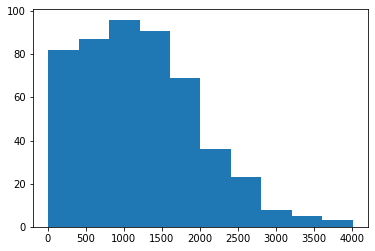

In [13]:
game_times = {i:matches[i]['game_time'] for i, _ in enumerate(matches)}
plt.hist(game_times.values())

In [ ]:
afk_players = pd.DataFrame()
for match in matches:
    for i, game in enumerate(match):
        if len(match['players'][i]['actions']) < 3:
            afk_players = afk_players.append(pd.DataFrame(data={'match_id_hash': match['match_id_hash'], 'afk': 1}, index=[i]))
        # else:
        #     afk_players = afk_players.append(pd.DataFrame(data={'afk_true': 0}, index=[match['match_id_hash']]))
            # print(f"player_slot {match['players'][i]['player_slot']} in match {match['match_id_hash']} was AFK")
afk_players

In [ ]:
afk_players = afk_players.groupby('match_id_hash').sum()
afk_players

In [18]:
%time
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)
            
afk_players = pd.DataFrame()   
# processing each game
for match in read_matches('./data/train_matches.jsonl'):
    
   # processing each player
    for i, player in enumerate(match['players']):
        if len(match['players'][i]['actions']) < 5:
            afk_players = afk_players.append(pd.DataFrame(data={'match_id_hash': match['match_id_hash'], 'afk': 1}, index=[i]))
        else:
            afk_players = afk_players.append(pd.DataFrame(data={'match_id_hash': match['match_id_hash'], 'afk': 0}, index=[i]))

Wall time: 1 ms


In [20]:
afk_players.shape

(396750, 2)

In [22]:
afk_players_ = afk_players.groupby('match_id_hash').sum().reset_index()
print(afk_players_.info())
afk_players_.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39675 entries, 0 to 39674
Data columns (total 2 columns):
match_id_hash    39675 non-null object
afk              39675 non-null int64
dtypes: int64(1), object(1)
memory usage: 620.0+ KB
None


,match_id_hash,afk
0,0000c270e25494c03d5c81036463fc45,0
1,0000cbef31e13f297dbbe47d84a08169,0
2,000432b654aee6e8792ce17bb19ccf16,0
3,000a2ba6b82a4a1829ca226a880ec993,0
4,000a9891b8b7712e9a19e032b583023e,0


In [26]:
X_train_ = hstack([X_train, afk_players_['afk'].values.reshape(-1,1)])

In [27]:
cv_score = cross_val_score(logit, 
                           X_train_, train_targets.values,
                           scoring='roc_auc', cv=skf)

print(cv_score)
print(f'mean: {cv_score.mean()}')
print(f'max: {cv_score.max()}')

[0.81019597 0.82514151 0.80976963 0.82163809 0.82838056 0.81569125
 0.8107013  0.81317112 0.8189952  0.82248843]
mean: 0.8176173066310588
max: 0.8283805621100968
